In [177]:
!git commit -m 'pushing updated transfer nb'


[master aa7bbf9] pushing updated transfer nb
 1 file changed, 1523 insertions(+), 538 deletions(-)
 rewrite vision_analyze/ex_transfer.ipynb (92%)


In [178]:
!git pull

remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18 (delta 14), reused 18 (delta 14), pack-reused 0
Unpacking objects: 100% (18/18), done.
From github.com:csinva/dl_theory
   b6ffb32..89a4888  master     -> origin/master


In [175]:
!git add  ex_transfer.ipynb

In [176]:
!git checkout ex_weights.ipynb

In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/mnist_5_5'
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/mnist_5_5_flip'
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/cifar10_5_5_flip'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/all_flips'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/all_flips_big'
fnames = sorted([fname for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 48/48 [00:00<00:00, 60.79it/s]


**add cols**

In [4]:
# results.keys()

In [5]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
print(results.shape)

(38, 88)


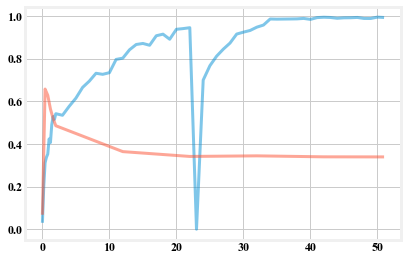

In [6]:
plt.plot(its, results['accs_train'][43])
plt.plot(ts, results['corr0'][43])

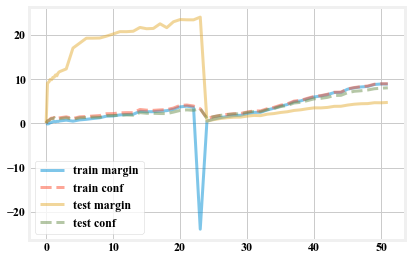

In [9]:
plt.plot(its, results.margin_unn_train[1], label='train margin')
plt.plot(its, results.confidence_unn_train[1], linestyle='--', label='train conf')

plt.plot(its, np.abs(results.margin_unn_test[1]), label='test margin')
plt.plot(its, results.confidence_unn_test[1], linestyle='--', label='test conf')

plt.legend()

In [10]:
idxs = results.index
mid_idx = 30
results['mid_train_acc'] = np.array([results.accs_train[i][mid_idx] for i in idxs]) 
results['mid_train_margin'] = np.array([results.margin_norm_train[i][mid_idx] for i in idxs]) 
results['mid_train_margin_unn'] = np.array([results.margin_unn_train[i][mid_idx] for i in idxs]) 
results['mid_test_margin'] = np.array([results.margin_norm_test[i][mid_idx] for i in idxs]) 
results['mid_test_margin_unn'] = np.array([results.margin_unn_test[i][mid_idx] for i in idxs]) 
results['mid_train_confidence_unn'] = np.array([results.confidence_unn_train[i][mid_idx] for i in idxs]) 
results['mid_test_confidence_unn'] = np.array([results.confidence_unn_test[i][mid_idx] for i in idxs]) 



results['final_train_acc'] = np.array([results.accs_train[i][-1] for i in idxs]) 
results['final_test_acc'] = np.array([results.accs_test[i][-1] for i in idxs]) 
results['final_train_margin'] = np.array([results.margin_norm_train[i][-1] for i in idxs]) 
results['final_train_margin_unn'] = np.array([results.margin_unn_train[i][-1] for i in idxs]) 
results['final_test_margin'] = np.array([results.margin_norm_test[i][-1] for i in idxs]) 
results['final_test_margin_unn'] = np.array([results.margin_unn_test[i][-1] for i in idxs]) 
results['final_train_confidence_unn'] = np.array([results.confidence_unn_train[i][-1] for i in idxs]) 
results['final_test_confidence_unn'] = np.array([results.confidence_unn_test[i][-1] for i in idxs]) 

results['mid_corr0'] = np.array([results.corr0[i][8] for i in idxs]) 

In [12]:
sweep_params = ['num_layers', 'optimizer', 'lr', 'dset']# wanna group by everything but seed
r = results
r_mu = r.groupby(sweep_params).mean()
# r_std = r.groupby(sweep_params).std()

Text(0.5,0,'Final test margin/ Test Confidence just before flip')

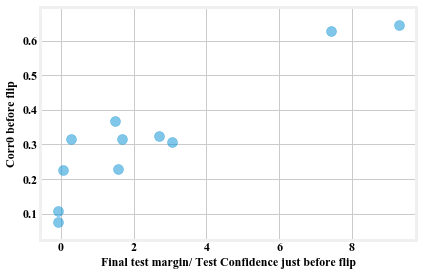

In [13]:
plt.scatter(
    r_mu['final_test_margin_unn']
           -
    r_mu['mid_test_confidence_unn']
             , 
#            r_mu.corr0_final,
    r_mu.mid_corr0
)
plt.ylabel('Corr0 before flip')
plt.xlabel('Final test margin/ Test Confidence just before flip')

# Visualize first layer of these 12 networks or at least a few good/bad ones..

In [14]:
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

In [147]:
results[['dset','lr', 'optimizer', 'num_layers', 
         'hidden_size','mid_train_confidence_unn',
         'mid_train_acc','final_train_acc', 'final_test_acc',
          'corr0_final']][(results['num_layers']==4)
                                                    &(results['dset']!='mnist_5_5_flip')].sort_values(
    by=['optimizer','final_test_acc'])

,dset,lr,optimizer,num_layers,hidden_size,mid_train_confidence_unn,mid_train_acc,final_train_acc,final_test_acc,corr0_final
1,cifar10_5_5_flip,0.100,adam,4,128,3.903528,0.88004,0.97064,0.7090,0.275012
41,cifar10_5_5_flip,1.000,adam,4,128,3.978291,0.86772,0.97024,0.7170,0.278112
38,cifar10_5_5_flip,0.100,adam,4,128,4.091345,0.89468,0.97036,0.7194,0.273102
32,cifar10_5_5_flip,1.000,adam,4,128,3.856310,0.87860,0.97440,0.7218,0.279358
43,cifar10_5_5_flip,1.000,adam,4,1024,6.920992,0.94580,0.99372,0.7472,0.339330
26,cifar10_5_5_flip,0.100,adam,4,1024,7.651115,0.94880,0.99684,0.7474,0.341649
37,cifar10_5_5_flip,1.000,adam,4,1024,6.606058,0.93148,0.99320,0.7526,0.340663
3,cifar10_5_5_flip,0.001,sgd,4,1024,0.051839,0.43440,0.43664,0.4412,0.070535
47,cifar10_5_5_flip,0.001,sgd,4,1024,0.065139,0.40840,0.45096,0.4504,0.070219
44,cifar10_5_5_flip,0.001,sgd,4,128,0.108003,0.47892,0.48368,0.4830,0.083866


In [155]:
idxs = [43, 5]
idxs = [32, 45]
dsets = ['cifar10', 'cifar10']

idxs = [25, 14]
dsets = ['mnist', 'mnist']

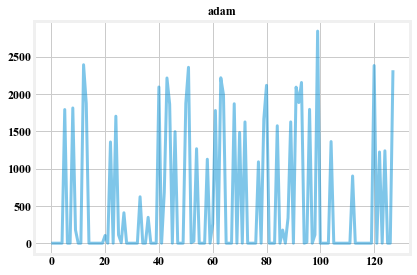

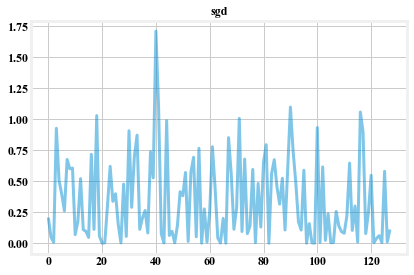

In [156]:
plt.plot(np.linalg.norm(rw.weights[idxs[0]][51]['fc.0.weight']-rw.weights[idxs[0]][22]['fc.0.weight'], axis=1),
#         bins=100
        )
plt.title(results.optimizer[idxs[0]])
plt.show()
plt.plot(np.linalg.norm(rw.weights[idxs[1]][51]['fc.0.weight']-rw.weights[idxs[1]][22]['fc.0.weight'], axis=1),
#         bins=100
        )
plt.title(results.optimizer[idxs[1]])
plt.show()



In [157]:
print(sum(np.linalg.norm(rw.weights[idxs[0]][51]['fc.0.weight']-
                          rw.weights[idxs[0]][32]['fc.0.weight'], axis=1)==0))
sum(np.linalg.norm(rw.weights[idxs[1]][51]['fc.0.weight']-
                          rw.weights[idxs[1]][32]['fc.0.weight'], axis=1)==0)

85


3

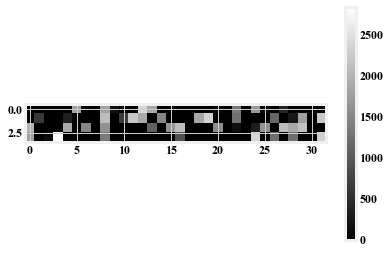

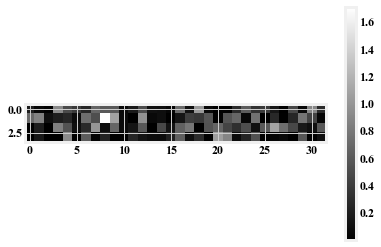

In [158]:
plt.imshow(np.linalg.norm(rw.weights[idxs[0]][51]['fc.0.weight']-
                          rw.weights[idxs[0]][22]['fc.0.weight'], axis=1).reshape(-1, 32),
           
          cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(np.linalg.norm(rw.weights[idxs[1]][51]['fc.0.weight']-
                          rw.weights[idxs[1]][22]['fc.0.weight'], axis=1).reshape(-1, 32),
          cmap='gray')
plt.colorbar()

In [173]:
idx = idxs[0]
dset = dsets[0]
# viz_weights.plot_weights(rw.weights[idx][22]['fc.0.weight'], dset=dset)
# plt.savefig('adam_128_5.pdf', bbox_inches = 'tight', pad_inches = 0)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight'], dset=dset)

# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight']-rw.weights[idx][32]['fc.0.weight'], dset=dset)
# plt.savefig('adam_difference.pdf', bbox_inches = 'tight', pad_inches = 0)

In [170]:
idx = idxs[1]
dset = dsets[1]

# viz_weights.plot_weights(rw.weights[idx][22]['fc.0.weight'], dset=dset)
# plt.savefig('sgd_128_5.pdf', bbox_inches = 'tight', pad_inches = 0)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight'], dset=dset)
# viz_weights.plot_weights(rw.weights[idx][51]['fc.0.weight']-rw.weights[idx][32]['fc.0.weight'], dset=dset)
# plt.tight_layout()
# plt.savefig('sgd_difference.pdf', bbox_inches = 'tight', pad_inches = 0)

In [172]:
# viz_weights.plot_weights(rw.weights[idxs[0]][51]['fc.0.weight'][24:40]
#                          -rw.weights[idxs[0]][32]['fc.0.weight'][24:40], dset)
# viz_weights.plot_weights(rw.weights[idxs[1]][51]['fc.0.weight'][24:40]
#                          -rw.weights[idxs[1]][32]['fc.0.weight'][24:40], dset)

In [101]:
# plt.imshow(rw.weights[idx][51]['fc.0.weight'][24].reshape(28, 28), cmap='gray')
# plt.grid(False)

# Linear Span

In [301]:
'/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/freeze_transfer'

(0.4438695, 0.37530208)

In [122]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
import numpy as np
import models
import random
import time
import numpy.linalg as npl
from numpy.linalg import norm as norm
from numpy.linalg import inv as inv

In [123]:
def relu(x):
    return np.maximum(0, x)
def process_loaders_local(train_loader, test_loader):
    # need to load like this to ensure transformation applied
    data_list_train = [batch for batch in train_loader]
    train_data_list = [batch[0] for batch in data_list_train]
    train_data = np.vstack(train_data_list)
    X_train = torch.Tensor(train_data).float()
    Y_train = np.hstack([batch[1] for batch in data_list_train])

    data_list_test = [batch for batch in test_loader]
    test_data_list = [batch[0] for batch in data_list_test]
    test_data = np.vstack(test_data_list)
    X_test = torch.Tensor(test_data).float()
    Y_test = np.hstack([batch[1] for batch in data_list_test])
    
    return X_train, Y_train, X_test, Y_test

In [124]:
didx='mnist'

In [125]:
transforms_noise = []
trans = transforms.Compose(transforms_noise + [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

if didx=='mnist':
    root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data/mnist')
    train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
    test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)
else:
    root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data/cifar10')
    train_set = dset.CIFAR10(root=root, train=True, transform=trans, download=True)
    test_set = dset.CIFAR10(root=root, train=False, transform=trans, download=True)

batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_set, 
                batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, 
                batch_size=batch_size, shuffle=True)

X_train, Y_train, X_test, Y_test = process_loaders_local(train_loader, test_loader)
if didx=='mnist':
    X_train = np.asarray(X_train.reshape(-1, 784))
    X_test  = np.asarray(X_test.reshape(-1, 784))
else:
    X_train = np.asarray(X_train.reshape(-1, 3072))
    X_test  = np.asarray(X_test.reshape(-1, 3072))

In [126]:
results[['dset','lr', 'optimizer', 'num_layers', 
         'hidden_size','mid_train_confidence_unn',
         'mid_train_acc','final_train_acc', 'final_test_acc',
          'corr0_final']][(results['num_layers']==4)
                                                    &(results['dset']!='mnist_5_5_flip')].sort_values(
    by=['optimizer','final_test_acc'])

,dset,lr,optimizer,num_layers,hidden_size,mid_train_confidence_unn,mid_train_acc,final_train_acc,final_test_acc,corr0_final
1,cifar10_5_5_flip,0.100,adam,4,128,3.903528,0.88004,0.97064,0.7090,0.275012
41,cifar10_5_5_flip,1.000,adam,4,128,3.978291,0.86772,0.97024,0.7170,0.278112
38,cifar10_5_5_flip,0.100,adam,4,128,4.091345,0.89468,0.97036,0.7194,0.273102
32,cifar10_5_5_flip,1.000,adam,4,128,3.856310,0.87860,0.97440,0.7218,0.279358
43,cifar10_5_5_flip,1.000,adam,4,1024,6.920992,0.94580,0.99372,0.7472,0.339330
26,cifar10_5_5_flip,0.100,adam,4,1024,7.651115,0.94880,0.99684,0.7474,0.341649
37,cifar10_5_5_flip,1.000,adam,4,1024,6.606058,0.93148,0.99320,0.7526,0.340663
3,cifar10_5_5_flip,0.001,sgd,4,1024,0.051839,0.43440,0.43664,0.4412,0.070535
47,cifar10_5_5_flip,0.001,sgd,4,1024,0.065139,0.40840,0.45096,0.4504,0.070219
44,cifar10_5_5_flip,0.001,sgd,4,128,0.108003,0.47892,0.48368,0.4830,0.083866


In [127]:
if didx=='mnist':
    idxs = [10, 15]
    dsets = ['mnist', 'mnist']
else:
    idxs = [32, 45]
    dsets = ['cifar10', 'cifar10']


results[['dset','lr', 'optimizer', 'num_layers', 
         'hidden_size','mid_train_confidence_unn',
         'mid_train_acc','final_train_acc', 'final_test_acc',
          'corr0_final']].loc[idxs]

,dset,lr,optimizer,num_layers,hidden_size,mid_train_confidence_unn,mid_train_acc,final_train_acc,final_test_acc,corr0_final
10,mnist_5_5_flip,1.0,adam,4,128,12.648044,0.993824,0.993186,0.969796,0.587785
15,mnist_5_5_flip,1.0,sgd,4,128,7.615953,0.993464,0.994339,0.974490,0.307500


In [128]:
w1 = rw.weights[idxs[0]][22]['fc.0.weight'].T
w2 = rw.weights[idxs[1]][22]['fc.0.weight'].T

Pw1 = w1 @ np.linalg.inv(w1.T @ w1) @ w1.T
Pw2 = w2 @ np.linalg.inv(w2.T @ w2) @ w2.T

In [129]:
norm(Pw2.dot(w1))/norm(w1), norm(Pw1.dot(w2))/norm(w2)

(0.9049138, 0.93362916)

In [138]:
a1 = X_train[:batch_size,:].dot(w1)
a2 = X_train[:batch_size,:].dot(w2)

P1 = a1 @ npl.pinv(a1.T @ a1) @ a1.T
P2 = a2 @ npl.pinv(a2.T @ a2) @ a2.T

In [139]:
norm(P2.dot(a1))/norm(a1), norm(P1.dot(a2))/norm(a2)

(1.0055656, 1.0500506)

In [136]:
ar1 = relu(a1)
ar2 = relu(a2)

Pr1 = ar1 @ npl.pinv(ar1.T @ ar1) @ ar1.T
Pr2 = ar2 @ npl.pinv(ar2.T @ ar2) @ ar2.T

In [137]:
norm(Pr2.dot(ar1))/norm(ar1), norm(Pr1.dot(ar2))/norm(ar2)

(0.95209825, 0.9338865)